In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import utils as mutil
import sklearn
import sklearn.tree
import sklearn.model_selection

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

## Load the data

In [2]:
titanic_train = pd.read_csv("titanic/train.csv")
titanic_train_ids = titanic_train['PassengerId']
titanic_test = pd.read_csv("titanic/test.csv")
titanic_test_ids = titanic_test['PassengerId']
titanic_test.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Kelly, Mr. James",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


In [3]:
# Data exploration
display(titanic_train.groupby('Embarked')['Embarked'].count())
print(titanic_train['Embarked'].count(), '/', titanic_train['PassengerId'].count())

print(titanic_train['Age'].count(), '/', titanic_train['PassengerId'].count())

titanic_test.describe(include='all')

Embarked
C    168
Q     77
S    644
Name: Embarked, dtype: int64

889 / 891
714 / 891


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.000000,418.000000,418,418,332.000000,418.000000,418.000000,418,417.000000,91,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,76,3
top,NaN,NaN,"Kelly, Mr. James",male,NaN,NaN,NaN,PC 17608,NaN,B57 B59 B63 B66,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,3,270
mean,1100.500000,2.265550,NaN,NaN,30.272590,0.447368,0.392344,NaN,35.627188,NaN,NaN
std,120.810458,0.841838,NaN,NaN,14.181209,0.896760,0.981429,NaN,55.907576,NaN,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,996.250000,1.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1204.750000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.500000,NaN,NaN


## Preprocess the data to increase the usability for our ML techniques
__Transformations:__
* The Cabin feature is not usable in its current form but it contains the information if the person had a cabin or not, so we can extract that information
    * Cabin => yes (1) | no (0)
* The sibling (SibSp) and parent (Parch) features are very simillar and can be combined into a family size parameter to describe the circumstances more concise and therfore make it easier for our model to learn
    * SibSp + Parch => Family size
* The embarked column has 2 missing entries, we can fill those with the most common option 'S'
<!--     * Then we can map it into a numerical value to make it more interoperable with numeric ML techniques -->
* Age has many missing values so we will replace the missing values with the mean of the column
    * Another option would be to replace missing values with random values using the standard deviation curve arround the mean and variance of the Age column
* In the test data the Fare column has missing values as well, we also fill these with the mean of that column

### Sources:
* https://www.kaggle.com/code/sinakhorami/titanic-best-working-classifier
* https://www.kaggle.com/code/dmilla/introduction-to-decision-trees-titanic-dataset/notebook

In [4]:

def preprocess(orig_df: pd.DataFrame):
    df = orig_df.copy()
    embarked_map = {'S': 0, 'C': 1, 'Q': 2}
    drop_columns = ['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin']
    df['Had Cabin'] = df['Cabin'].map(lambda c: 0 if type(c) != str else 1)
    df['Family size'] = df['SibSp'] + df['Parch']
    df['Embarked'] = df['Embarked'].fillna('S').map(lambda c: embarked_map[c])
    df['Sex'] = df['Sex'].map(lambda c: 0 if c == 'male' else 1)
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df['Fare'] = df['Fare'].fillna(df['Fare'].mean())

    # Drop all unused columns
    df = df.drop(columns=drop_columns)
    return df
    
titanic_train_clean = preprocess(titanic_train)
#titanic_train[['SibSp', 'Parch', 'Family size']]

In [5]:
# Print expected influence of the features on our prediction models
printmd("### Print expected influence of the features on our prediction models")

print(titanic_train_clean[['Had Cabin', 'Survived']].groupby(['Had Cabin']).mean())
# It looks like passangers without a cabin had worse chances of surviving

print(titanic_train_clean[['Family size', 'Survived']].groupby(['Family size']).mean())
# Very varying mean accross the family size so we expect it to have a significant impact onto our dataset

print(titanic_train_clean[['Embarked', 'Survived']].groupby(['Embarked']).mean())
# Should also have a significant effect due to varying means accross classes

### Print expected influence of the features on our prediction models

           Survived
Had Cabin          
0          0.299854
1          0.666667
             Survived
Family size          
0            0.303538
1            0.552795
2            0.578431
3            0.724138
4            0.200000
5            0.136364
6            0.333333
7            0.000000
10           0.000000
          Survived
Embarked          
0         0.339009
1         0.553571
2         0.389610


In [6]:
titanic_train_clean.describe(include='all')

,Survived,Pclass,Sex,Age,Fare,Embarked,Had Cabin,Family size
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.352413,29.699118,32.204208,0.361392,0.228956,0.904602
std,0.486592,0.836071,0.477990,13.002015,49.693429,0.635673,0.420397,1.613459
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,7.910400,0.000000,0.000000,0.000000
50%,0.000000,3.000000,0.000000,29.699118,14.454200,0.000000,0.000000,0.000000
75%,1.000000,3.000000,1.000000,35.000000,31.000000,1.000000,0.000000,1.000000
max,1.000000,3.000000,1.000000,80.000000,512.329200,2.000000,1.000000,10.000000


In [7]:
titanic_train_clean.groupby("Survived")['Survived'].count()

Survived
0    549
1    342
Name: Survived, dtype: int64

## Search for the best descision tree configuration

In [8]:
cross_folds = sklearn.model_selection.KFold(n_splits=5)
parameter_set = [{'max_depth': d} for d in range(1, 8)] # 1 to number of attributes + 1 

accuracies = []

for ps in parameter_set:
    print(f"Running for parameter set {ps} ...")
    model = sklearn.tree.DecisionTreeClassifier(**ps, class_weight="balanced")
    accuracies.append([])
    for train_fold, validation_fold in cross_folds.split(titanic_train_clean):
        # Create training dataset for fold
        train = titanic_train_clean.loc[train_fold]
        train_x = train.drop(columns=['Survived'])
        train_y = train['Survived']
        # Create validation dataset for fold
        valid = titanic_train_clean.loc[validation_fold]
        valid_x = valid.drop(columns=['Survived'])
        valid_y = valid['Survived']
        # Train model
        model = model.fit(X=train_x, y=train_y)
        # Calculate accuracy
        accuracy = model.score(X=valid_x, y=valid_y)
        accuracies[-1].append(accuracy)

for i, acc in enumerate(accuracies):
    print(f"Average of fold  with params {parameter_set[i]} is {sum(acc)/len(acc)} full data:\n\t {acc}")

# The best depth seems to be 4

Running for parameter set {'max_depth': 1} ...
Running for parameter set {'max_depth': 2} ...
Running for parameter set {'max_depth': 3} ...
Running for parameter set {'max_depth': 4} ...
Running for parameter set {'max_depth': 5} ...
Running for parameter set {'max_depth': 6} ...
Running for parameter set {'max_depth': 7} ...
Average of fold  with params {'max_depth': 1} is 0.7867239972380893 full data:
	 [0.8156424581005587, 0.797752808988764, 0.7808988764044944, 0.7359550561797753, 0.8033707865168539]
Average of fold  with params {'max_depth': 2} is 0.7620802209528592 full data:
	 [0.7486033519553073, 0.7696629213483146, 0.7696629213483146, 0.7359550561797753, 0.7865168539325843]
Average of fold  with params {'max_depth': 3} is 0.7834348126294646 full data:
	 [0.7430167597765364, 0.7808988764044944, 0.7921348314606742, 0.7752808988764045, 0.8258426966292135]
Average of fold  with params {'max_depth': 4} is 0.7912999811687904 full data:
	 [0.7430167597765364, 0.8089887640449438, 0.78

## Train our model based on this configuration estimation

In [9]:

# Create training dataset
train_x = titanic_train_clean.drop(columns=['Survived'])
train_y = titanic_train_clean['Survived']
# Train model based on best estimated configuration from previous tests
model = sklearn.tree.DecisionTreeClassifier(max_depth=5, class_weight="balanced")
model = model.fit(X=train_x, y=train_y)
# Calculate train accuracy
train_accuracy = model.score(X=train_x, y=train_y)
print(f"Train accuracy {train_accuracy}")
print(f"Training set utilisation = {100 * len(titanic_train_clean) / len(titanic_train)}%")

# Create test dataset
titanic_test_clean = preprocess(titanic_test)
# Calculate test accuracy
predictions = model.predict(X=titanic_test_clean)
submission_df = pd.DataFrame(data={'PassengerId': titanic_test['PassengerId'], 'Survived': predictions})
submission_df = submission_df.set_index('PassengerId')
submission_df

Train accuracy 0.8484848484848485
Training set utilisation = 100.0%


,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1
...,...
1305,0
1306,1
1307,0


In [10]:
submission_df.to_csv("Titanic_prediction-DescisionTree.csv")

## Evaluaton based on titanic test-set

In [11]:
titanic_test_with_labels = pd.read_csv("../../project/test-set-solution.csv")
titanic_test_with_labels = titanic_test_with_labels.drop(columns=["boat", "body", "home.dest"])
titanic_test_with_labels["PassengerId"] = [titanic_train.shape[0] + i for i in range(titanic_test_with_labels.shape[0])]
titanic_test_with_labels.head()

,Pclass,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,PassengerId
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.00,0,0,24160,211.3375,B5,S,891
1,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,892
2,1,0,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,893
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.00,1,2,113781,151.5500,C22 C26,S,894
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.00,1,2,113781,151.5500,C22 C26,S,895


Is there an onverlap with the training dataset?

In [12]:
merge = titanic_test_with_labels.merge(titanic_train, on=["Name"], how='left', indicator=True)
merge["duplicate"] = merge["_merge"] == "both"
merge.groupby("duplicate")["duplicate"].count()

duplicate
False    416
True     893
Name: duplicate, dtype: int64

Yes, so we need to clean that up

In [13]:
titanic_test_with_labels_u = titanic_test_with_labels.merge(titanic_train, on=["Name"], how='outer', indicator=True).query('_merge=="left_only"').drop("_merge", axis=1)
titanic_test_with_labels_u = titanic_test_with_labels_u.drop(columns=["PassengerId_y", "Survived_y", "Pclass_y", "Age_y", "SibSp_y", "Parch_y", "Ticket_y", "Embarked_y", "Sex_y", "Fare_y", "Cabin_y"])
titanic_test_with_labels_u.rename(columns={
    "Pclass_x": "Pclass",
    "Survived_x": "Survived",
    "Sex_x": "Sex",
    "Age_x": "Age",
    "SibSp_x": "SibSp", 
    "Parch_x": "Parch",
    "Ticket_x": "Ticket",
    "Fare_x": "Fare",
    "Cabin_x": "Cabin",
    "Embarked_x": "Embarked",
    "PassengerId_x": "PassengerId",}, inplace=True)
titanic_test_with_labels_u

,Pclass,Survived,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,PassengerId
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0,1,2,113781,151.5500,C22 C26,S,894
10,1,0,"Astor, Col. John Jacob",male,47.0,1,0,PC 17757,227.5250,C62 C64,C,901
19,1,0,"Beattie, Mr. Thomson",male,36.0,0,0,13050,75.2417,C6,C,910
24,1,1,"Bird, Miss. Ellen",female,29.0,0,0,PC 17483,221.7792,C97,S,915
25,1,0,"Birnbaum, Mr. Jakob",male,25.0,0,0,13905,26.0000,NaN,C,916
...,...,...,...,...,...,...,...,...,...,...,...,...
1291,3,0,"Willer, Mr. Aaron (""Abi Weller"")",male,NaN,0,0,3410,8.7125,NaN,S,2182
1296,3,0,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,2187
1298,3,0,"Wittevrongel, Mr. Camille",male,36.0,0,0,345771,9.5000,NaN,S,2189
1306,3,0,"Zakarian, Mr. Mapriededer",male,26.5,0,0,2656,7.2250,NaN,C,2197


### Now lets test our accuracy against the test set

In [14]:
# Create test dataset
titanic_test_with_labels_clean = preprocess(titanic_test_with_labels_u)
test_x = titanic_test_with_labels_clean.drop(columns=['Survived'])
test_y = titanic_test_with_labels_clean['Survived']
# Calculate test accuracy
titianic_test_score = model.score(X=test_x, y=test_y)
print(f"Test score = {titianic_test_score}")
print(f"Missing classifications = {len(titanic_test_with_labels_u) - len(titanic_test_with_labels_clean)}")

Test score = 0.75
Missing classifications = 0


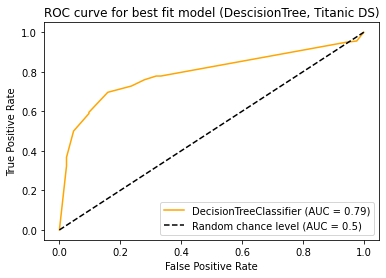

In [15]:
mutil.plot_roc(model, test_x, test_y, "ROC curve for best fit model (DescisionTree, Titanic DS)")

In [16]:
f1 = mutil.calc_f1(model, test_x, test_y)
print(f"Weighted F1-score = {f1}")

Weighted F1-score = 0.7522184546569511


In [17]:
pred_y = model.predict(test_x)
print(sklearn.metrics.classification_report(y_true=test_y, y_pred=pred_y))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       258
           1       0.65      0.73      0.69       158

    accuracy                           0.75       416
   macro avg       0.74      0.75      0.74       416
weighted avg       0.76      0.75      0.75       416



In [18]:
tree_graph = sklearn.tree.export_graphviz(model,
                filled=True, rounded=True,
                  special_characters=True, 
                  feature_names = titanic_train_clean.columns[1:],
                  class_names=['Died','Survived'])
with open("tmp-graphviz.graph", 'w') as f:
    f.write(tree_graph)

## Test some different model parameters

In [19]:
# Train model
model = sklearn.tree.DecisionTreeClassifier(max_depth=7, class_weight="balanced")
model = model.fit(X=train_x, y=train_y)

# Calculate train accuracy
train_accuracy = model.score(X=train_x, y=train_y)
print(f"Train accuracy {train_accuracy}")
print(f"Training set utilisation = {100 * len(titanic_train_clean) / len(titanic_train)}%\n")

# Create test dataset
titanic_test_with_labels_clean = preprocess(titanic_test_with_labels_u)
test_x = titanic_test_with_labels_clean.drop(columns=['Survived'])
test_y = titanic_test_with_labels_clean['Survived']
# Calculate test accuracy
titianic_test_score = model.score(X=test_x, y=test_y)
print(f"Test score = {titianic_test_score}")
print(f"Missing classifications = {len(titanic_test_with_labels_u) - len(titanic_test_with_labels_clean)}")

Train accuracy 0.8686868686868687
Training set utilisation = 100.0%

Test score = 0.7355769230769231
Missing classifications = 0


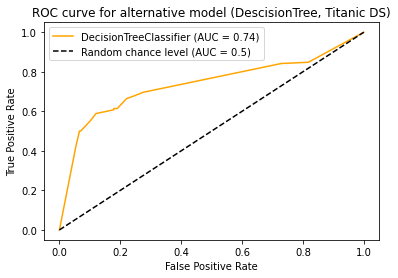

In [20]:
mutil.plot_roc(model, test_x, test_y, "ROC curve for alternative model (DescisionTree, Titanic DS)")

In [21]:
f1 = mutil.calc_f1(model, test_x, test_y)
print(f"Weighted F1-score = {f1}")

Weighted F1-score = 0.7361966646634616


In [22]:
pred_y = model.predict(test_x)
print(sklearn.metrics.classification_report(y_true=test_y, y_pred=pred_y))

              precision    recall  f1-score   support

           0       0.79      0.78      0.79       258
           1       0.65      0.66      0.66       158

    accuracy                           0.74       416
   macro avg       0.72      0.72      0.72       416
weighted avg       0.74      0.74      0.74       416



In [23]:
titanic_test_with_labels_clean

,Pclass,Survived,Sex,Age,Fare,Embarked,Had Cabin,Family size
3,1,0,0,30.000000,151.5500,0,1,3
10,1,0,0,47.000000,227.5250,1,1,1
19,1,0,0,36.000000,75.2417,1,1,0
24,1,1,1,29.000000,221.7792,0,1,0
25,1,0,0,25.000000,26.0000,1,0,0
...,...,...,...,...,...,...,...,...
1291,3,0,0,30.260606,8.7125,0,0,0
1296,3,0,0,27.000000,8.6625,0,0,0
1298,3,0,0,36.000000,9.5000,0,0,0
1306,3,0,0,26.500000,7.2250,1,0,0
